In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Master Thesis/Data/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Master Thesis/Data/test.csv")
stores = pd.read_csv("/content/drive/MyDrive/Master Thesis/Data/stores.csv")
items = pd.read_csv("/content/drive/MyDrive/Master Thesis/Data/items.csv")
trans = pd.read_csv("/content/drive/MyDrive/Master Thesis/Data/transactions.csv")
oil = pd.read_csv("/content/drive/MyDrive/Master Thesis/Data/oil.csv")
holidays = pd.read_csv("/content/drive/MyDrive/Master Thesis/Data/holidays_events.csv")

<ipython-input-3-d1d6c219e63c>:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("/content/drive/MyDrive/Master Thesis/Data/train.csv")


# Dataset Simplification

## Step 1: Train dataset filtering

Consolidation of a new CSV file containing only sales information for all items sold in 2015 and 2016

In [ ]:
# Filter items for the 'BREAD/BAKERY' category
bakery_items = items[items['family'] == 'BREAD/BAKERY']

# Merge the sales data with filtered item data
filtered_sales = pd.merge(train, bakery_items, on='item_nbr')

# Convert the 'date' column to datetime type
filtered_sales['date'] = pd.to_datetime(filtered_sales['date'])

# Filter by date to include data from January 2015 to december 2016 (2years)
filtered_sales = filtered_sales[
    (filtered_sales['date'].dt.year == 2015) |
    (filtered_sales['date'].dt.year == 2016)]

# Identify the store with the highest number of sales
store_counts = filtered_sales['store_nbr'].value_counts()
most_sales_store = store_counts.idxmax()

# Filter the data for the store with the most sales
most_sales_data = filtered_sales[filtered_sales['store_nbr'] == most_sales_store]

# Save the filtered data to a new CSV file
most_sales_data.to_csv("/content/drive/MyDrive/Master Thesis/Data/filtered_train_most_sales_store.csv", index=False)

print(f"The store with the highest number of sales for BREAD/BAKERY products is store number {most_sales_store} with {store_counts[most_sales_store]} entries.")

The store with the highest number of sales for BREAD/BAKERY products is store number 45 with 66587 entries.


Information on the store with the most sales


In [ ]:
store_info = stores[stores['store_nbr'] == 45]

print("Location details of store number 45:")
print(store_info)

Location details of store number 45:
    store_nbr   city      state type  cluster
44         45  Quito  Pichincha    A       11


 Some sales values are floating because some items are sold by weight. My aim is to identify these and remove them so as to have only items sold by quantity.

 In addition, I delete unnecessary columns that are the same for each line, such as family (all BREADS/BAKERY), store number (all 45) and perishables (all perishables).

In [ ]:
filtered_train = pd.read_csv("/content/drive/MyDrive/Master Thesis/Data/filtered_train_most_sales_store.csv")

# Display the first few rows to check the data
print("Before modification:")
print(filtered_train.head())

# Filter rows where 'unit_sales' is an integer
filtered_train = filtered_train[filtered_train['unit_sales'].apply(lambda x: x.is_integer())]

# Convert 'unit_sales' from float to int
filtered_train['unit_sales'] = filtered_train['unit_sales'].astype(int)

# Remove unnecessary columns
filtered_train = filtered_train.drop(['family', 'store_nbr', 'perishable'], axis=1)

filtered_train.onpromotion = filtered_train.onpromotion.astype("float16")
filtered_train['onpromotion'] = filtered_train['onpromotion'].astype(int)

# Save the modifications to the same file, overwriting existing data
filtered_train.to_csv("/content/drive/MyDrive/Master Thesis/Data/filtered_train_most_sales_store.csv", index=False)

# Reload to check the modifications
updated_data = pd.read_csv("/content/drive/MyDrive/Master Thesis/Data/filtered_train_most_sales_store.csv")
print("\nAfter modification:")
print(updated_data.head())

Before modification:
         id        date  store_nbr  item_nbr  unit_sales  onpromotion  \
0  38642776  2015-01-02         45    103665         8.0        False   
1  38704321  2015-01-03         45    103665         7.0        False   
2  38765417  2015-01-04         45    103665         6.0        False   
3  38825221  2015-01-05         45    103665         7.0        False   
4  38883044  2015-01-06         45    103665         3.0        False   

         family  class  perishable  
0  BREAD/BAKERY   2712           1  
1  BREAD/BAKERY   2712           1  
2  BREAD/BAKERY   2712           1  
3  BREAD/BAKERY   2712           1  
4  BREAD/BAKERY   2712           1  

After modification:
         id        date  item_nbr  unit_sales  onpromotion  class
0  38642776  2015-01-02    103665           8            0   2712
1  38704321  2015-01-03    103665           7            0   2712
2  38765417  2015-01-04    103665           6            0   2712
3  38825221  2015-01-05    103665

For the sake of simplification, I will only focus on forecasting the sales of the 2 best-selling products in the store.

In [ ]:
# Group the data by item number and sum the unit sales
grouped_data = filtered_train.groupby('item_nbr')['unit_sales'].sum().reset_index()

# Sort the data to find the top 5 items with the highest unit sales
top2_items = grouped_data.sort_values(by='unit_sales', ascending=False).head(2)

# Filter the original data to only include rows that belong to the top 2 items
top2_data_1 = filtered_train[filtered_train['item_nbr'].isin(top2_items['item_nbr'])]

# Ensure the 'date' column is in datetime format
top2_data_1['date'] = pd.to_datetime(top2_data_1['date'])

# Define a function to fill missing dates using the value from the same weekday of the previous week
def fill_missing_dates(group):
    # Create a complete date range for each group
    date_range = pd.date_range(start=group['date'].min(), end=group['date'].max())
    # Reindex the group
    group = group.set_index('date').reindex(date_range)
    # Backfill missing values from the same weekday of the previous week
    for date in group.index:
        if pd.isna(group.loc[date, 'item_nbr']):
            # Calculate the date exactly one week prior
            date_week_ago = date - pd.DateOffset(days=7)
            if date_week_ago in group.index:
                group.loc[date] = group.loc[date_week_ago]
    return group.reset_index().rename(columns={'index': 'date'})

# Group by 'item_nbr' and apply the function to fill missing dates
top2_data = top2_data_1.groupby('item_nbr').apply(fill_missing_dates).reset_index(drop=True)

# Save the updated data
top2_data.to_csv('/content/drive/MyDrive/Master Thesis/Data/train_top2.csv', index=False)

<ipython-input-7-cc799f697bb4>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top2_data_1['date'] = pd.to_datetime(top2_data_1['date'])


## Step 2: Variables dataset creation

Based on the files provided in the core dataset, my aim will be to consolidate a new file including relevant variables in 2015 and 2016 so that the algorithms can better identify trends and patterns.

The new variables are:

* Date related variables
* Maximum temperature of the day
* Minimum temperature of the day
* Special day variables
* Name of the locality
* Whether it's a special day
* Oil price of the day

First, based on the "holiday_event" file which includes special dates, I will create three binary variables to determine if for each day:

* If there is a national holiday.
* If there is a local holiday in the city of Quito.
* If there is a national event.(there are only national events)

I did not include regional because there are no holidays or events specific to the region in which Quito is located, which is Pichincha.

In [ ]:
# Load the dataset
special_day = pd.read_csv('/content/drive/MyDrive/Master Thesis/Data/holidays_events.csv')

# Convert 'date' column to datetime type
special_day['date'] = pd.to_datetime(special_day['date'])

# Define conditions for special day attributes
conditions = {
    'event_national': ((special_day['type'] == 'Event') & (special_day['locale'] == 'National')).astype(int),
    'holiday_national': ((special_day['type'] != 'Work Day') & (special_day['type'] != 'Event') & (special_day['locale'] == 'National')).astype(int),
    'holiday_local': ((special_day['type'] != 'Work Day') & (special_day['type'] != 'Event') & (special_day['locale_name'] == 'Quito')).astype(int),
}

# Apply the conditions to the original data
for column, condition in conditions.items():
    special_day[column] = condition

# Reduce the special_day to only necessary columns
special_day = special_day[['date', 'event_national', 'holiday_national', 'holiday_local']]

# Save to CSV
special_day.to_csv('/content/drive/MyDrive/Master Thesis/Data/special_day.csv', index=False)

print(special_day.head())

        date  event_national  holiday_national  holiday_local
0 2012-03-02               0                 0              0
1 2012-04-01               0                 0              0
2 2012-04-12               0                 0              0
3 2012-04-14               0                 0              0
4 2012-04-21               0                 0              0


Next, I will create several variables related to the date. These are:

* The month
* The day of the month
* The week of the month
* The day of the week
* The year
* The season
* If it's a working day or not
* If it's the payday or not.

Transforming Cyclical Features:
Cyclical features such as days of the week or months of the year are not linear (e.g., after December comes January), but standard numeric encoding can mislead the model into treating them as ordinal variables. To address this, we can use sine and cosine transformations to maintain the cyclicity of these variables.

In [ ]:
# Creating a date range DataFrame
dates = pd.date_range(start='2015-01-01', end='2017-01-01', freq='D')
df_date = pd.DataFrame(dates, columns=['date'])

# Merge with the special_day DataFrame, filling missing values with 0
df_date = df_date.merge(special_day, on='date', how='left').fillna(0)
df_date[['event_national', 'holiday_national', 'holiday_local']] = df_date[['event_national', 'holiday_national', 'holiday_local']].astype(int)

# Adding additional columns with numerical variables
df_date['month'] = df_date['date'].dt.month.astype("int8")
df_date['day_of_month'] = df_date['date'].dt.day.astype("int8")
df_date['week_of_month'] = ((df_date['date'].dt.day - 1) // 7 + 1).astype("int8")
df_date['day_of_week'] = (df_date['date'].dt.dayofweek + 1).astype("int8")
df_date['year'] = df_date['date'].dt.year.astype("int32")


# Function to determine the season
def get_season(month):
    if month in [3, 4, 5]:
        return 1  # Spring
    elif month in [6, 7, 8]:
        return 2  # Summer
    elif month in [9, 10, 11]:
        return 3  # Autumn
    else:
        return 0  # Winter

df_date['season'] = df_date['month'].apply(get_season).astype("int8")


# Workday column
df_date["workday"] = np.where(
    (df_date["day_of_week"].isin([6, 7])) |  # weekend condition
    (df_date["holiday_local"] == 1) |       # local holiday condition
    (df_date["holiday_national"] == 1),     # national holiday condition
    0,                                      # if any condition is true, then 0 (not a workday)
    1                                       # otherwise, 1 (it is a workday)
).astype("int8")


df_date["wageday"] = np.where((df_date["day_of_month"] == 30) | (df_date["day_of_month"] == 15), 1, 0).astype("int8")

# Transform 'day_of_week', 'month', 'day_of_month', 'day_of_year', 'week_of_month', and 'week_of_year' using sine and cosine
for feature, max_value in zip(['month', 'day_of_month', 'week_of_month', 'day_of_week', 'season'],
                              [12, 31, 5, 7, 4]):  # max values based on the highest number each feature can take
    df_date[f'{feature}_sin'] = np.sin(df_date[feature] * (2. * np.pi / max_value))
    df_date[f'{feature}_cos'] = np.cos(df_date[feature] * (2. * np.pi / max_value))

# Display the final DataFrame
print(df_date.head())

        date  event_national  holiday_national  holiday_local  month  \
0 2015-01-01               0                 1              0      1   
1 2015-01-02               0                 1              0      1   
2 2015-01-03               0                 0              0      1   
3 2015-01-04               0                 0              0      1   
4 2015-01-05               0                 0              0      1   

   day_of_month  week_of_month  day_of_week  year  season  ...  month_sin  \
0             1              1            4  2015       0  ...        0.5   
1             2              1            5  2015       0  ...        0.5   
2             3              1            6  2015       0  ...        0.5   
3             4              1            7  2015       0  ...        0.5   
4             5              1            1  2015       0  ...        0.5   

   month_cos  day_of_month_sin  day_of_month_cos  week_of_month_sin  \
0   0.866025          0.201299   

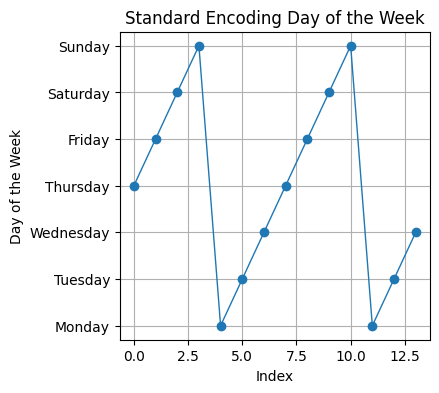

In [ ]:
# Standard Encoding

two_weeks_data = df_date.head(14)

plt.figure(figsize=(4, 4))
plt.plot(two_weeks_data['day_of_week'], marker='o', linestyle='-', markersize=6, linewidth=1)
plt.xlabel('Index')
plt.ylabel('Day of the Week')
plt.title('Standard Encoding Day of the Week')
plt.yticks(ticks=range(1, 8), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.grid(True)
plt.show()

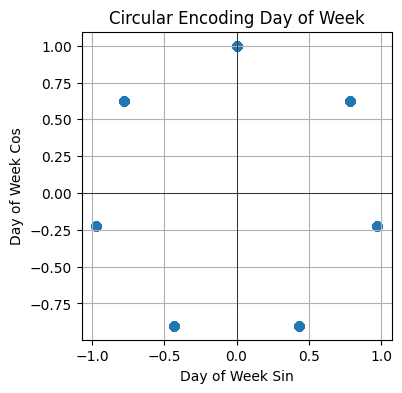

In [ ]:
# Plotting the circular plot for day of the week
plt.figure(figsize=(4, 4))
plt.scatter(df_date['day_of_week_sin'], df_date['day_of_week_cos'])
plt.title('Circular Encoding Day of Week')
plt.xlabel('Day of Week Sin')
plt.ylabel('Day of Week Cos')
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.show()

In [ ]:
# Load the weather data
weather_data_path = '/content/drive/MyDrive/Master Thesis/Data/weather.csv'
weather_df = pd.read_csv(weather_data_path)
weather_df['datetime'] = pd.to_datetime(weather_df['datetime'])

# Merge the weather DataFrame with the date DataFrame
df_date = pd.merge(df_date, weather_df, left_on='date', right_on='datetime', how='left')
df_date.drop(columns='datetime', inplace=True)  # Drop the duplicate datetime column

# Load oil data
oil_data_path = '/content/drive/MyDrive/Master Thesis/Data/oil.csv'
oil_df = pd.read_csv(oil_data_path)
oil_df['date'] = pd.to_datetime(oil_df['date'])

# Merge oil data with the df_date DataFrame and rename the oil price column
oil_df.rename(columns={'dcoilwtico': 'oil_price'}, inplace=True)
df_date = pd.merge(df_date, oil_df, on='date', how='left')  # Use 'on' instead of 'left_on' and 'right_on'
df_date['oil_price'].fillna(np.nan, inplace=True)  # Ensure all missing oil prices are NaN

# Save the final DataFrame
variables_data_path = '/content/drive/MyDrive/Master Thesis/Data/variables.csv'
df_date.to_csv(variables_data_path, index=False)

## Step 3: Merge the two files to create the new dataset


In [ ]:
# Load the sales data of the top 2 item
sales_data_path = '/content/drive/MyDrive/Master Thesis/Data/train_top2.csv'
train_top2_df = pd.read_csv(sales_data_path)

variables_data_path = '/content/drive/MyDrive/Master Thesis/Data/variables.csv'
variables_df = pd.read_csv(variables_data_path)

# Ensure both 'date' columns in the dataframes are converted to datetime
train_top2_df['date'] = pd.to_datetime(train_top2_df['date'])
variables_df['date'] = pd.to_datetime(variables_df['date'])

# Rename 'Date' in variables_df to 'date'
variables_df.rename(columns={'date': 'date'}, inplace=True)

# Perform the merge operation using 'date' as the key, ensuring to use the column from the train_top5_df
final_dataset_df = pd.merge(train_top2_df, variables_df, on='date', how='left')

# Add a new column 'item_name' based on the values in 'items_nbr'
final_dataset_df['item_name'] = final_dataset_df['item_nbr'].map({
    502331: 'A',
    1333307: 'B'
})

# Save the merged DataFrame to a new CSV file
final_dataset_path = '/content/drive/MyDrive/Master Thesis/Final Data/final_dataset.csv'
final_dataset_df.to_csv(final_dataset_path, index=False)

Data quality check

In [ ]:
# Load the dataset
data_check = pd.read_csv('/content/drive/MyDrive/Master Thesis/Final Data/final_dataset.csv')

# Display the first few rows
print(data_check.head())

# Display the last few rows
print(data_check.tail())

# Print the shape of the dataset
print("Number of rows:", data_check.shape[0])
print("Number of columns:", data_check.shape[1])

         date        id  item_nbr  unit_sales  onpromotion  class  \
0  2015-01-02  38643255    502331         117        False   2702   
1  2015-01-03  38704801    502331         110        False   2702   
2  2015-01-04  38765895    502331         180        False   2702   
3  2015-01-05  38825684    502331         106        False   2702   
4  2015-01-06  38883513    502331          87        False   2702   

   event_national  holiday_national  holiday_local  month  ...  \
0           False              True          False      1  ...   
1           False             False          False      1  ...   
2           False             False          False      1  ...   
3           False             False          False      1  ...   
4           False             False          False      1  ...   

   week_of_month_sin  week_of_month_cos  day_of_week_sin  day_of_week_cos  \
0           0.951057           0.309017    -9.749279e-01        -0.222521   
1           0.951057           0.3

In [ ]:
# Display data types of each column
print(data_check.dtypes)

# Count missing values in each column
print(data_check.isnull().sum())

date                  object
id                     int64
item_nbr               int64
unit_sales             int64
onpromotion             bool
class                  int64
event_national          bool
holiday_national        bool
holiday_local           bool
month                  int64
day_of_month           int64
week_of_month          int64
day_of_week            int64
year                   int64
season                 int64
workday                 bool
wageday                 bool
month_sin            float64
month_cos            float64
day_of_month_sin     float64
day_of_month_cos     float64
week_of_month_sin    float64
week_of_month_cos    float64
day_of_week_sin      float64
day_of_week_cos      float64
season_sin           float64
season_cos           float64
tempmax              float64
tempmin              float64
oil_price            float64
item_name             object
dtype: object
date                 0
id                   0
item_nbr             0
unit_sales        

In [ ]:
# Convert to the right type
file_path = '/content/drive/MyDrive/Master Thesis/Final Data/final_dataset.csv'
df = pd.read_csv(file_path)

# Change the variable types
df = df.astype({
    'id': 'int',
    'onpromotion': 'bool',
    'item_nbr': 'int',
    'unit_sales': 'int',
    'class': 'int',
    'event_national': 'bool',
    'holiday_national': 'bool',
    'holiday_local': 'bool',
    'workday': 'bool',
    'wageday': 'bool'
})

# Convert the 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Save the modified DataFrame back to a CSV file
df.to_csv(file_path, index=False)

print("Data types after conversion:")
print(df.dtypes)

Data types after conversion:
date                 datetime64[ns]
id                            int64
item_nbr                      int64
unit_sales                    int64
onpromotion                    bool
class                         int64
event_national                 bool
holiday_national               bool
holiday_local                  bool
month                         int64
day_of_month                  int64
week_of_month                 int64
day_of_week                   int64
year                          int64
season                        int64
workday                        bool
wageday                        bool
month_sin                   float64
month_cos                   float64
day_of_month_sin            float64
day_of_month_cos            float64
week_of_month_sin           float64
week_of_month_cos           float64
day_of_week_sin             float64
day_of_week_cos             float64
season_sin                  float64
season_cos                  float64

## Step 4: Data processing for models


Remove outliers from the data (days where the unit_sales is above 300) and remove the duplicates

In [ ]:
# Load the data
data_final = pd.read_csv('/content/drive/MyDrive/Master Thesis/Final Data/final_dataset.csv')

# Convert 'date' to datetime if not already
data_final['date'] = pd.to_datetime(data_final['date'])

# Remove outliers
filtered_data = data_final[data_final['unit_sales'] <= 250]

# Remove duplicate dates within each item name, keeping the first occurrence
filtered_data = filtered_data.drop_duplicates(subset=['item_name', 'date'], keep='first')

# Save the filtered data back to the CSV file
filtered_data.to_csv('/content/drive/MyDrive/Master Thesis/Final Data/final_dataset.csv', index=False)

Fill the missing values of the final dataset: oil price

Forward Filling: This method propagates the last observed non-null value forward until another non-null value is encountered. It's particularly useful in time series where data points are likely to be similar to their immediate predecessors.

In [ ]:
# Load the final_dataset CSV into a DataFrame
data_final = pd.read_csv('/content/drive/MyDrive/Master Thesis/Final Data/final_dataset.csv')

# Forward fill the missing values in the 'oil_price' column
data_final['oil_price'] = data_final['oil_price'].fillna(method='ffill')

# If the first value(s) in 'oil_price' are still NaN (because forward fill cannot fill them), fill them with the column's mean
if data_final['oil_price'].isnull().any():
    data_final['oil_price'] = data_final['oil_price'].fillna(data_final['oil_price'].mean())

# Check if there are still any missing values in the 'oil_price' column
missing_values = data_final['oil_price'].isnull().sum()

if missing_values > 0:
    print("There are still", missing_values, "missing values in the 'oil_price' column.")
else:
    print("There are no missing values in the 'oil_price' column.")

# Save the filtered data back to the original CSV file
data_final.to_csv('/content/drive/MyDrive/Master Thesis/Final Data/final_dataset.csv', index=False)

There are no missing values in the 'oil_price' column.
